# This is the in situ and SSS collocation code. 


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import xarray as xr
import scipy
from glob import glob
import cartopy.crs as ccrs
from pyresample.geometry import AreaDefinition
from pyresample import image, geometry, load_area, save_quicklook, SwathDefinition
from pyresample.kd_tree import resample_nearest
import sys
sys.path.append('../saildrone/subroutines/')
from read_routines import read_one_usv, add_coll_vars,get_filelist_l2p,get_orbital_data_l2p
import warnings
warnings.simplefilter('ignore') # filter some warning messages


# Read in USV data
Read in the Saildrone USV file either from a local disc or using OpenDAP.



In [2]:
dir_data = 'f:/data/cruise_data/saildrone/saildrone_data/'
dir_data_pattern = 'f:/data/cruise_data/saildrone/saildrone_data/*west*.nc' 

#get list of all filenames in directory
files = glob(dir_data_pattern)
print('number of file:',len(files))
for ifile,file in enumerate(files):
    print(ifile,file)

number of file: 13
0 f:/data/cruise_data/saildrone/saildrone_data\saildrone_west_coast_survey_2018_sd1024.nc
1 f:/data/cruise_data/saildrone/saildrone_data\saildrone_west_coast_survey_2018_sd1025.nc
2 f:/data/cruise_data/saildrone/saildrone_data\saildrone_west_coast_survey_2018_sd1026.nc
3 f:/data/cruise_data/saildrone/saildrone_data\saildrone_west_coast_survey_2018_sd1027.nc
4 f:/data/cruise_data/saildrone/saildrone_data\saildrone_west_coast_survey_2018_sd1028.nc
5 f:/data/cruise_data/saildrone/saildrone_data\saildrone_west_coast_survey_2019_sd1038.nc
6 f:/data/cruise_data/saildrone/saildrone_data\saildrone_west_coast_survey_2019_sd1039.nc
7 f:/data/cruise_data/saildrone/saildrone_data\saildrone_west_coast_survey_2019_sd1040.nc
8 f:/data/cruise_data/saildrone/saildrone_data\saildrone_west_coast_survey_2019_sd1043.nc
9 f:/data/cruise_data/saildrone/saildrone_data\saildrone_west_coast_survey_2019_sd1044.nc
10 f:/data/cruise_data/saildrone/saildrone_data\saildrone_west_coast_survey_2019_

In [53]:
#filename_usv='f:/data/cruise_data/saildrone/baja-2018/saildrone-gen_4-baja_2018-sd1002-20180411T180000-20180611T055959-1_minutes-v1.nc'
#filename_usv='f:/data/cruise_data/saildrone/baja-2018/saildrone-gen_4-baja_2018-sd1002-20180411T180000-20180611T055959-1_minutes-v1.nc'
iname=0
ds_usv=[]
for file in files:
    ds = read_one_usv(file)
    ds_usv.append(ds[0])
ds_usv=xr.concat(ds_usv,dim='trajectory')
#ds_usv = xr.open_mfdataset(files,concat_dim='trajectory')
#ds_usv.close()
#ds_usv = ds_usv.isel(trajectory=0).swap_dims({'obs':'time'}).rename({'longitude':'lon','latitude':'lat'})
#ds_usv = ds_usv.sel(time=slice('2018-04-12T02','2018-06-10T18')) #get rid of last part and first part where USV being towed
#ds_usv['lon'] = ds_usv.lon.interpolate_na(dim='time',method='linear') #there are 6 nan values
#ds_usv['lat'] = ds_usv.lat.interpolate_na(dim='time',method='linear')
ds_usv['wind_speed']=np.sqrt(ds_usv.UWND_MEAN**2+ds_usv.VWND_MEAN**2)
ds_usv['wind_dir']=np.arctan2(ds_usv.VWND_MEAN,ds_usv.UWND_MEAN)*180/np.pi
#ds_usv

In [54]:
ds_usv

<xarray.Dataset>
Dimensions:                       (time: 350468, trajectory: 13)
Coordinates:
  * time                          (time) datetime64[ns] 2018-06-27 ... 2019-0...
  * trajectory                    (trajectory) object '1024.0' ... 1.047e+03
Data variables: (12/27)
    lat                           (trajectory, time) float64 nan nan ... nan nan
    lon                           (trajectory, time) float64 nan nan ... nan nan
    SOG_MEAN                      (trajectory, time) float64 nan nan ... nan nan
    COG_MEAN                      (trajectory, time) float64 nan nan ... nan nan
    HDG_MEAN                      (trajectory, time) float64 nan nan ... nan nan
    PITCH_MEAN                    (trajectory, time) float64 nan nan ... nan nan
    ...                            ...
    TEMP_O2_RBR_MEAN              (trajectory, time) float64 nan nan ... nan nan
    CDOM_MEAN                     (trajectory, time) float64 nan nan ... nan nan
    CHLOR_WETLABS_MEAN            (trajectory, time) float64 nan nan ... nan nan
    WIND_MEASUREMENT_HEIGHT_MEAN  (trajectory, time) float64 nan nan ... nan nan
    wind_speed                    (trajectory, time) float64 nan nan ... nan nan
    wind_dir                      (trajectory, time) float64 nan nan ... nan nan
Attributes: (12/47)
    area:                      unassigned
    cdm_data_type:             Trajectory
    cdm_trajectory_variables:  trajectory
    Conventions:               CF-1.6, COARDS, ACDD-1.3
    creator_email:             support@saildrone.com
    creator_name:              Saildrone
    ...                        ...
    time_coverage_resolution:  PT1M
    time_coverage_start:       2018-07-17T18:00:00Z
    title:                     Saildrone West Coast Survey 2018
    uuid:                      3e4ce677-18db-4ba8-9c73-f2c1f3ad15ce
    Westernmost_Easting:       -124.915008
    vehicle_id:                sd1024

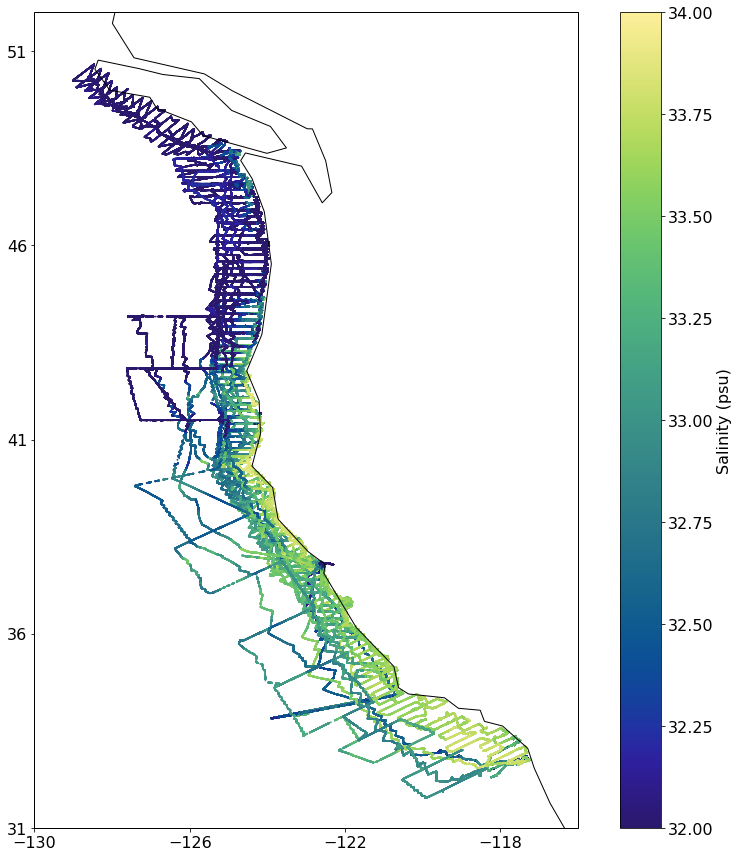

In [5]:
plt.rcParams['figure.figsize'] = (15.0, 15.0)
plt.rcParams.update({'font.size': 16})
import cmocean
for i in range(len(ds_usv.trajectory)):
    ds=ds_usv.isel(trajectory=i)
    ax = plt.axes(projection=ccrs.PlateCarree())
    cs1 = ax.scatter(ds.lon, ds.lat, s=3.0, c=ds.SAL_CTD_MEAN, edgecolor='none', cmap=cmocean.cm.haline,vmin=32,vmax=34)
ax.coastlines()
#cs1.set_fontsize(16)
x1,x2,y1,y2 = -130,-116,31,52
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
ax.set_xticks(np.arange(x1,x2,4))
ax.set_yticks(np.arange(y1,y2,5))
cax = plt.colorbar(cs1)
cax.set_label('Salinity (psu)',fontsize=16)
fig_fname = 'C:/Users/gentemann/Google Drive/f_drive/docs/projects/SSS/figures/west_coast_all_cruises.png'
plt.savefig(fig_fname, transparent=False, format='png')

In [6]:
np.datetime64('2019-06-19')

numpy.datetime64('2019-06-19')

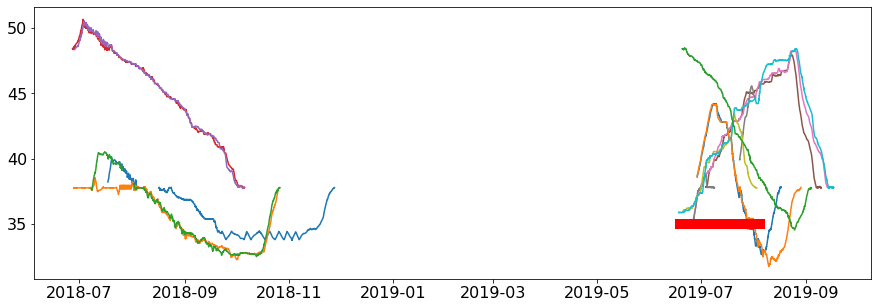

In [7]:
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.rcParams.update({'font.size': 16})
import cmocean
for i in range(len(ds_usv.trajectory)):
    ds=ds_usv.isel(trajectory=i)
    #ax = plt.axes(projection=ccrs.PlateCarree())
    plt.plot(ds.time,ds.lat)
    plt.plot([np.datetime64('2019-06-19'),np.datetime64('2019-08-05')],[35,35],'r',linewidth=10) #DATA OUTAGE
fig_fname = 'C:/Users/gentemann/Google Drive/f_drive/docs/projects/SSS/figures/west_coast_all_cruises_timeseries.png'
plt.savefig(fig_fname, transparent=False, format='png')

In [8]:
dir_data = 'F:/data/cruise_data/saildrone/sss/sss_collocations_orbital_norepeat/' #'f:/data/cruise_data/saildrone/saildrone_data/'
dir_data_patternJ = 'F:/data/cruise_data/saildrone/sss/sss_collocations_orbital_norepeat/*west*JPL*.nc' 
dir_data_patternR = 'F:/data/cruise_data/saildrone/sss/sss_collocations_orbital_norepeat/*west*RSS*.nc' 

#get list of all filenames in directory
cfilesJ = glob(dir_data_patternJ)
cfilesR = glob(dir_data_patternR)
print('number of file:',len(cfilesR))
for ifile,file in enumerate(cfilesJ):
    print(ifile,file)

number of file: 13
0 F:/data/cruise_data/saildrone/sss/sss_collocations_orbital_norepeat\saildrone_west_coast_survey_2018_sd1024jplv05.0_orbitalnorep.nc
1 F:/data/cruise_data/saildrone/sss/sss_collocations_orbital_norepeat\saildrone_west_coast_survey_2018_sd1025jplv05.0_orbitalnorep.nc
2 F:/data/cruise_data/saildrone/sss/sss_collocations_orbital_norepeat\saildrone_west_coast_survey_2018_sd1026jplv05.0_orbitalnorep.nc
3 F:/data/cruise_data/saildrone/sss/sss_collocations_orbital_norepeat\saildrone_west_coast_survey_2018_sd1027jplv05.0_orbitalnorep.nc
4 F:/data/cruise_data/saildrone/sss/sss_collocations_orbital_norepeat\saildrone_west_coast_survey_2018_sd1028jplv05.0_orbitalnorep.nc
5 F:/data/cruise_data/saildrone/sss/sss_collocations_orbital_norepeat\saildrone_west_coast_survey_2019_sd1038jplv05.0_orbitalnorep.nc
6 F:/data/cruise_data/saildrone/sss/sss_collocations_orbital_norepeat\saildrone_west_coast_survey_2019_sd1039jplv05.0_orbitalnorep.nc
7 F:/data/cruise_data/saildrone/sss/sss_col

In [56]:
ds2=[]
for i in range(len(cfilesJ)):
    ds = xr.open_dataset(cfilesJ[i])
    ds2.append(ds)
ds_colJ = xr.concat(ds2,dim='trajectory')
ds2=[]
for i in range(len(cfilesR)):
    ds = xr.open_dataset(cfilesR[i])
    ds2.append(ds)
ds_colR = xr.concat(ds2,dim='trajectory')
ds_colR['wind_speed']=np.sqrt(ds_colR.UWND_MEAN**2+ds_colR.VWND_MEAN**2)
ds_colJ['wind_speed']=np.sqrt(ds_colJ.UWND_MEAN**2+ds_colJ.VWND_MEAN**2)


In [57]:
ds_colJ

<xarray.Dataset>
Dimensions:                       (ob: 324, trajectory: 13)
Coordinates:
  * ob                            (ob) int64 0 1 2 3 4 5 ... 319 320 321 322 323
  * trajectory                    (trajectory) object '1024.0' ... 1.047e+03
Data variables: (12/37)
    lat                           (trajectory, ob) float64 38.23 38.24 ... nan
    lon                           (trajectory, ob) float64 -123.9 -124.0 ... nan
    SOG_MEAN                      (trajectory, ob) float64 1.539 1.505 ... nan
    COG_MEAN                      (trajectory, ob) float64 279.1 283.6 ... nan
    HDG_MEAN                      (trajectory, ob) float64 287.2 291.7 ... nan
    PITCH_MEAN                    (trajectory, ob) float64 2.697 2.714 ... nan
    ...                            ...
    smap_ydim                     (trajectory, ob) float32 18.0 19.0 ... nan nan
    smap_xdim                     (trajectory, ob) float32 1.04e+03 ... nan
    smap_rev_number               (trajectory, ob) float64 1.847e+04 ... nan
    dist_land                     (trajectory, ob) float64 65.26 66.82 ... nan
    time                          (trajectory, ob) datetime64[ns] 2018-07-17T...
    wind_speed                    (trajectory, ob) float64 8.607 8.603 ... nan
Attributes: (12/47)
    area:                      unassigned
    cdm_data_type:             Trajectory
    cdm_trajectory_variables:  trajectory
    Conventions:               CF-1.6, COARDS, ACDD-1.3
    creator_email:             support@saildrone.com
    creator_name:              Saildrone
    ...                        ...
    time_coverage_resolution:  PT1M
    time_coverage_start:       2018-07-17T18:00:00Z
    title:                     Saildrone West Coast Survey 2018
    uuid:                      3e4ce677-18db-4ba8-9c73-f2c1f3ad15ce
    Westernmost_Easting:       -124.915008
    vehicle_id:                sd1024

In [94]:
ds_colR

<xarray.Dataset>
Dimensions:                       (ob: 306, trajectory: 13)
Coordinates:
  * ob                            (ob) int64 0 1 2 3 4 5 ... 301 302 303 304 305
  * trajectory                    (trajectory) object '1024.0' ... 1.047e+03
Data variables: (12/38)
    lat                           (trajectory, ob) float64 38.24 38.25 ... nan
    lon                           (trajectory, ob) float64 -124.0 -124.0 ... nan
    SOG_MEAN                      (trajectory, ob) float64 1.573 1.695 ... nan
    COG_MEAN                      (trajectory, ob) float64 280.8 289.4 ... nan
    HDG_MEAN                      (trajectory, ob) float64 289.0 296.1 ... nan
    PITCH_MEAN                    (trajectory, ob) float64 2.744 3.123 ... nan
    ...                            ...
    smap_ydim                     (trajectory, ob) float32 512.0 512.0 ... nan
    smap_xdim                     (trajectory, ob) float32 405.0 ... nan
    smap_rev_number               (trajectory, ob) float64 1.848e+04 ... nan
    dist_land                     (trajectory, ob) float64 66.22 70.48 ... nan
    time                          (trajectory, ob) datetime64[ns] 2018-07-17T...
    wind_speed                    (trajectory, ob) float64 8.684 9.125 ... nan
Attributes: (12/47)
    area:                      unassigned
    cdm_data_type:             Trajectory
    cdm_trajectory_variables:  trajectory
    Conventions:               CF-1.6, COARDS, ACDD-1.3
    creator_email:             support@saildrone.com
    creator_name:              Saildrone
    ...                        ...
    time_coverage_resolution:  PT1M
    time_coverage_start:       2018-07-17T18:00:00Z
    title:                     Saildrone West Coast Survey 2018
    uuid:                      3e4ce677-18db-4ba8-9c73-f2c1f3ad15ce
    Westernmost_Easting:       -124.915008
    vehicle_id:                sd1024

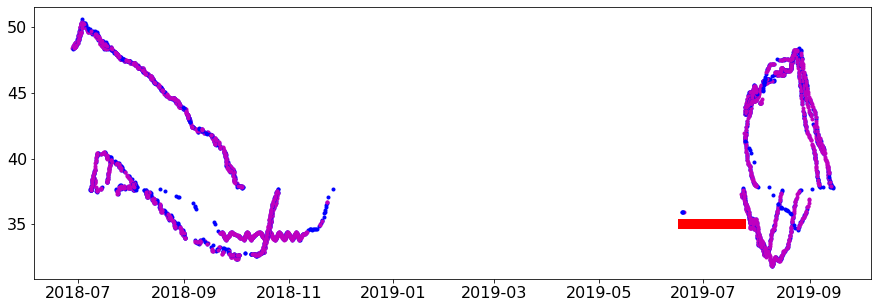

In [11]:
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.rcParams.update({'font.size': 16})
import cmocean
for i in range(len(ds_usv.trajectory)):
    ds=ds_colJ.isel(trajectory=i)
    plt.plot(ds.time,ds.lat,'.',color='b',linewidth=3)
    ds=ds_colR.isel(trajectory=i)
    plt.plot(ds.time,ds.lat,'.',color='m')
    plt.plot([np.datetime64('2019-06-19'),np.datetime64('2019-07-23')],[35,35],'r',linewidth=10) #DATA OUTAGE
fig_fname = 'C:/Users/gentemann/Google Drive/f_drive/docs/projects/SSS/figures/west_coast_coll_cruises_timeseriesJPL.png'
plt.savefig(fig_fname, transparent=False, format='png')

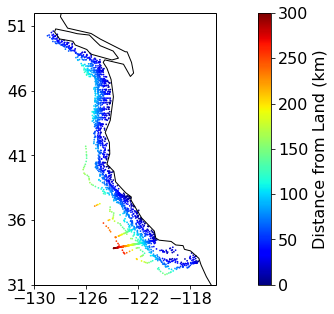

In [12]:
#for i in range(13):
#    ds=ds_colJ.isel(trajectory=i)
#    ds = ds.where(ds.dist_land>30)
#    ax = plt.axes(projection=ccrs.PlateCarree())
#    cs1 = ax.scatter(ds.lon, ds.lat, s=3.0, c=ds.dist_land, edgecolor='none', cmap='jet',vmin=0,vmax=300)
#ax.coastlines()
#cs1.set_fontsize(16)
#x1,x2,y1,y2 = -130,-116,31,52
#ax.set_xlim(x1,x2)
#ax.set_ylim(y1,y2)
#ax.set_xticks(np.arange(x1,x2,4))
#ax.set_yticks(np.arange(y1,y2,5))
#cax = plt.colorbar(cs1)
#cax.set_label('Distance from Land (km)',fontsize=16)
#fig_fname = 'C:/Users/gentemann/Google Drive/f_drive/docs/projects/SSS/figures/west_coast_collocations_distanceJPL.png'
#plt.savefig(fig_fname, transparent=False, format='png')



for i in range(13):
    ds=ds_colJ.isel(trajectory=i)
    ax = plt.subplot(121,projection=ccrs.PlateCarree())
    cs1 = ax.scatter(ds.lon, ds.lat, s=3.0, c=ds.dist_land, edgecolor='none', cmap='jet',vmin=0,vmax=300)
ax.coastlines()
#cs1.set_fontsize(16)
x1,x2,y1,y2 = -130,-116,31,52
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
ax.set_xticks(np.arange(x1,x2,4))
ax.set_yticks(np.arange(y1,y2,5))
cax = plt.colorbar(cs1)
cax.set_label('Distance from Land (km)',fontsize=16)
for i in range(13):
    ds=ds_colR.isel(trajectory=i)
    ax = plt.subplot(122,projection=ccrs.PlateCarree())
    cs1 = ax.scatter(ds.lon, ds.lat, s=3.0, c=ds.dist_land, edgecolor='none', cmap='jet',vmin=0,vmax=300)
ax.coastlines()
#cs1.set_fontsize(16)
x1,x2,y1,y2 = -130,-116,31,52
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
ax.set_xticks(np.arange(x1,x2,4))
ax.set_yticks(np.arange(y1,y2,5))
cax = plt.colorbar(cs1)
cax.set_label('Distance from Land (km)',fontsize=16)
fig_fname = 'C:/Users/gentemann/Google Drive/f_drive/docs/projects/SSS/figures/west_coast_collocations_distance.png'
plt.savefig(fig_fname, transparent=False, format='png')

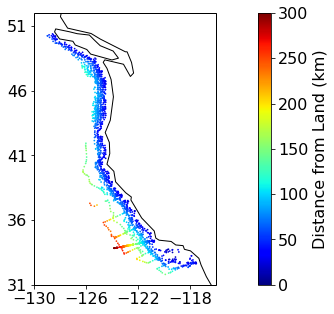

In [13]:
for i in range(13):
    ds=ds_colR.isel(trajectory=i)
    ax = plt.axes(projection=ccrs.PlateCarree())
    cs1 = ax.scatter(ds.lon, ds.lat, s=3.0, c=ds.dist_land, edgecolor='none', cmap='jet',vmin=0,vmax=300)
ax.coastlines()
#cs1.set_fontsize(16)
x1,x2,y1,y2 = -130,-116,31,52
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
ax.set_xticks(np.arange(x1,x2,4))
ax.set_yticks(np.arange(y1,y2,5))
cax = plt.colorbar(cs1)
cax.set_label('Distance from Land (km)',fontsize=16)
fig_fname = 'C:/Users/gentemann/Google Drive/f_drive/docs/projects/SSS/figures/west_coast_collocations_distanceRSS.png'
plt.savefig(fig_fname, transparent=False, format='png')

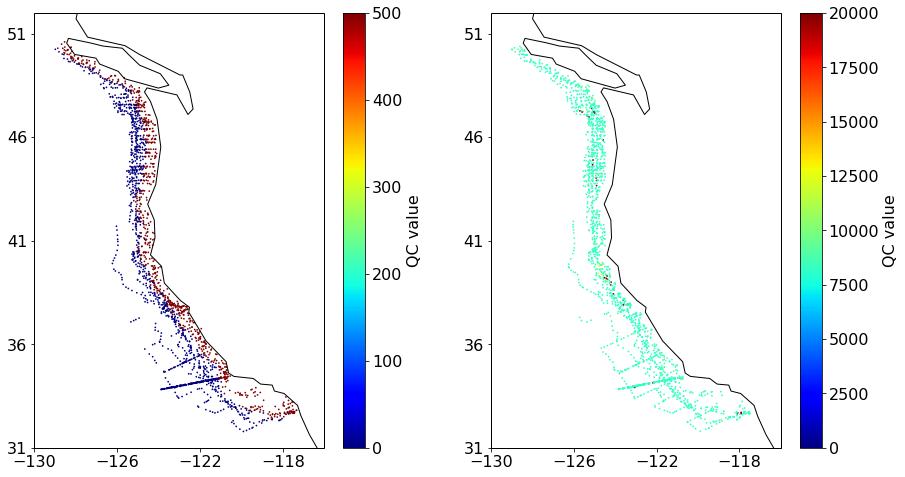

In [35]:
for i in range(13):
    ds=ds_colJ.isel(trajectory=i)
    ax = plt.subplot(121,projection=ccrs.PlateCarree())
    cs1 = ax.scatter(ds.lon, ds.lat, s=3.0, c=ds.smap_iqc_flag, edgecolor='none', cmap='jet',vmin=0,vmax=500)
ax.coastlines()
#cs1.set_fontsize(16)
x1,x2,y1,y2 = -130,-116,31,52
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
ax.set_xticks(np.arange(x1,x2,4))
ax.set_yticks(np.arange(y1,y2,5))
cax = plt.colorbar(cs1)
cax.set_label('QC value',fontsize=16)
for i in range(13):
    ds=ds_colR.isel(trajectory=i)
    ax = plt.subplot(122,projection=ccrs.PlateCarree())
    cs1 = ax.scatter(ds.lon, ds.lat, s=3.0, c=ds.smap_iqc_flag, edgecolor='none', cmap='jet',vmin=0,vmax=20000)
ax.coastlines()
#cs1.set_fontsize(16)
x1,x2,y1,y2 = -130,-116,31,52
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
ax.set_xticks(np.arange(x1,x2,4))
ax.set_yticks(np.arange(y1,y2,5))
cax = plt.colorbar(cs1)
cax.set_label('QC value',fontsize=16)
fig_fname = 'C:/Users/gentemann/Google Drive/f_drive/docs/projects/SSS/figures/west_coast_collocations_qc.png'
plt.savefig(fig_fname, transparent=False, format='png')

# above what we are seeing
- JPL on left, near land flagged, 
- RSS on right, all dat flagged as light-land-contami - and some rain flags

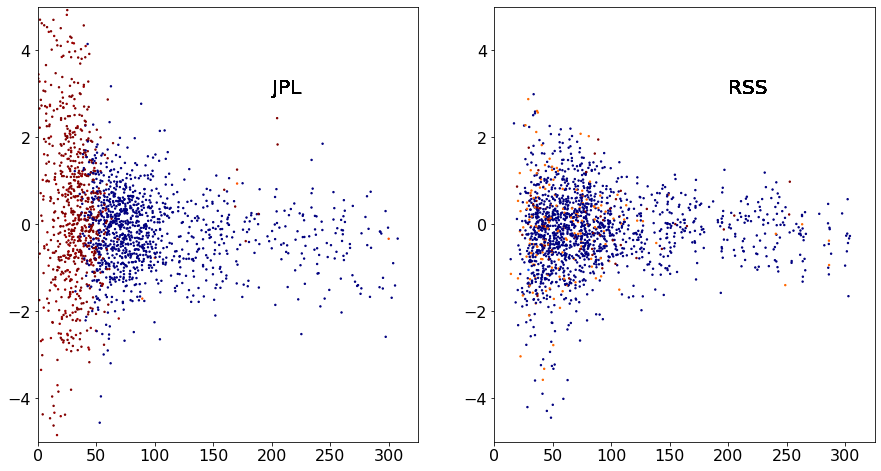

In [105]:
for i in range(13):
    ds=ds_colJ.isel(trajectory=i)
    #ds = ds.where( (ds.smap_iqc_flag<1))
    ax = plt.subplot(121)
    plt.scatter(ds.dist_land,ds.SAL_CTD_MEAN-ds.smap_SSS,s=2,c=ds.smap_iqc_flag,cmap='jet')
    plt.text(200,3,'JPL',fontsize=20)
    plt.xlim(0,325),plt.ylim(-5,5)
for i in range(13):
    ds=ds_colR.isel(trajectory=i)
    ds = ds.where((ds.SAL_CTD_MEAN>26) & (ds.smap_iqc_flag<10000))
    ax = plt.subplot(122)
    plt.scatter(ds.dist_land,ds.SAL_CTD_MEAN-ds.smap_SSS,s=2,c=ds.smap_iqc_flag,cmap='jet')
    plt.text(200,3,'RSS',fontsize=20)
    plt.xlim(0,325),plt.ylim(-5,5)
fig_fname = 'C:/Users/gentemann/Google Drive/f_drive/docs/projects/SSS/figures/west_coast_collocations_distance_land.png'
plt.savefig(fig_fname, transparent=False, format='png')

In [47]:
ds

<xarray.Dataset>
Dimensions:                       (ob: 306)
Coordinates:
  * ob                            (ob) int64 0 1 2 3 4 5 ... 301 302 303 304 305
    trajectory                    float64 1.047e+03
Data variables: (12/37)
    lat                           (ob) float64 34.72 34.9 35.01 ... nan nan nan
    lon                           (ob) float64 -121.0 -121.1 -121.2 ... nan nan
    SOG_MEAN                      (ob) float64 0.8468 0.9945 0.6778 ... nan nan
    COG_MEAN                      (ob) float64 113.7 246.6 302.6 ... nan nan nan
    HDG_MEAN                      (ob) float64 110.4 279.8 300.3 ... nan nan nan
    PITCH_MEAN                    (ob) float64 -0.2013 -0.3245 ... nan nan
    ...                            ...
    smap_dist                     (ob) float64 0.1517 0.08698 0.1486 ... nan nan
    smap_ydim                     (ob) float32 498.0 499.0 499.0 ... nan nan nan
    smap_xdim                     (ob) float32 1.131e+03 1.131e+03 ... nan nan
    smap_rev_number               (ob) float64 2.438e+04 2.438e+04 ... nan nan
    dist_land                     (ob) float64 31.68 32.26 33.13 ... nan nan nan
    time                          (ob) datetime64[ns] 2019-08-25T11:30:00 ......
Attributes: (12/47)
    area:                      unassigned
    cdm_data_type:             Trajectory
    cdm_trajectory_variables:  trajectory
    Conventions:               CF-1.6, COARDS, ACDD-1.3
    creator_email:             support@saildrone.com
    creator_name:              Saildrone
    ...                        ...
    time_coverage_resolution:  PT1M
    time_coverage_start:       2018-07-17T18:00:00Z
    title:                     Saildrone West Coast Survey 2018
    uuid:                      3e4ce677-18db-4ba8-9c73-f2c1f3ad15ce
    Westernmost_Easting:       -124.915008
    vehicle_id:                sd1024

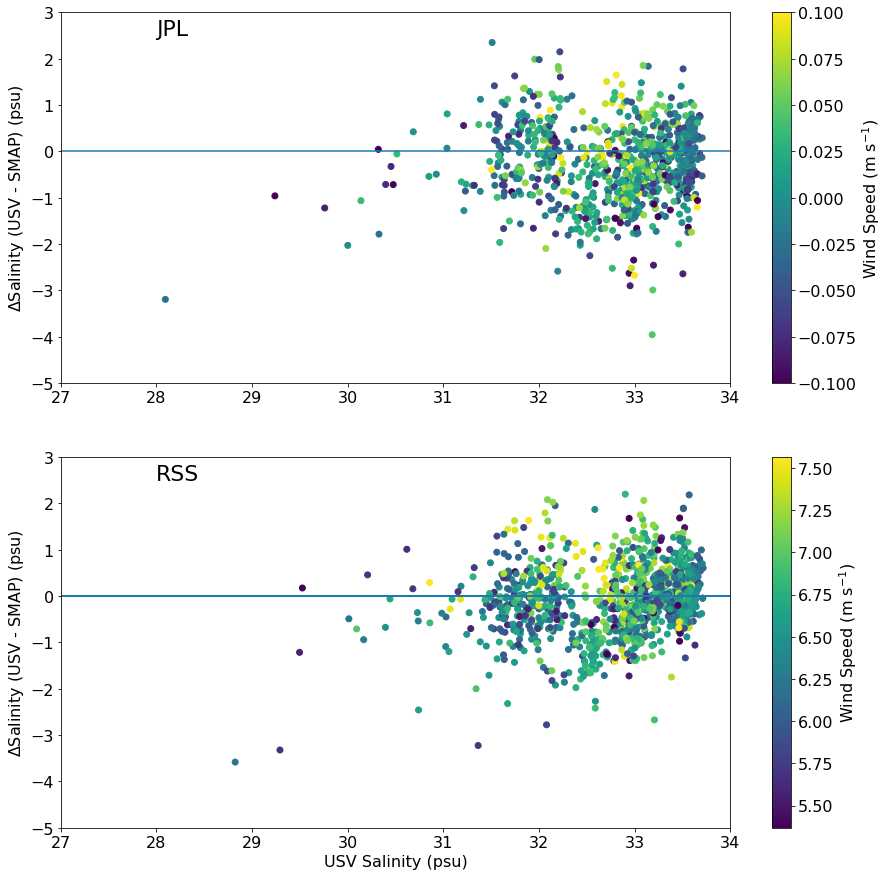

In [89]:
plt.rcParams['figure.figsize'] = (15.0,15.0)
plt.rcParams.update({'font.size': 16})
for i in range(13):
    ds = ds_colJ.isel(trajectory=i)
    ds = ds.where((ds.dist_land>100) & (ds.SAL_CTD_MEAN>26) & (ds.smap_iqc_flag<1)) #removes near land
    dif = ds.SAL_CTD_MEAN-ds.smap_SSS
    plt.subplot(2,1,1)
    plt.scatter(ds.SAL_CTD_MEAN,dif,c=ds.wind_speed)
plt.axhline(0)
plt.text(28,2.5,'JPL',fontsize=22)
plt.xlim(27,34),plt.ylim(-5,3),plt.ylabel('$\Delta$Salinity (USV - SMAP) (psu)')
cb=plt.colorbar(label='Wind Speed (m s$^{-1}$)')
for i in range(13):
    ds = ds_colR.isel(trajectory=i)
    ds = ds.where((ds.dist_land>100) & (ds.smap_iqc_flag<10000)) #leaves in light land cont
    dif = ds.SAL_CTD_MEAN-ds.smap_SSS
    plt.subplot(2,1,2)
    plt.axhline(0)
    plt.scatter(ds.SAL_CTD_MEAN,dif,c=ds.wind_speed)
plt.text(28,2.5,'RSS',fontsize=22)
plt.xlim(27,34),plt.ylim(-5,3),plt.ylabel('$\Delta$Salinity (USV - SMAP) (psu)'),plt.xlabel('USV Salinity (psu)')
cb=plt.colorbar(label='Wind Speed (m s$^{-1}$)')
fig_fname = 'C:/Users/gentemann/Google Drive/f_drive/docs/projects/SSS/figures/west_coast_collocations_sal_scatter.png'
plt.savefig(fig_fname, transparent=False, format='png')

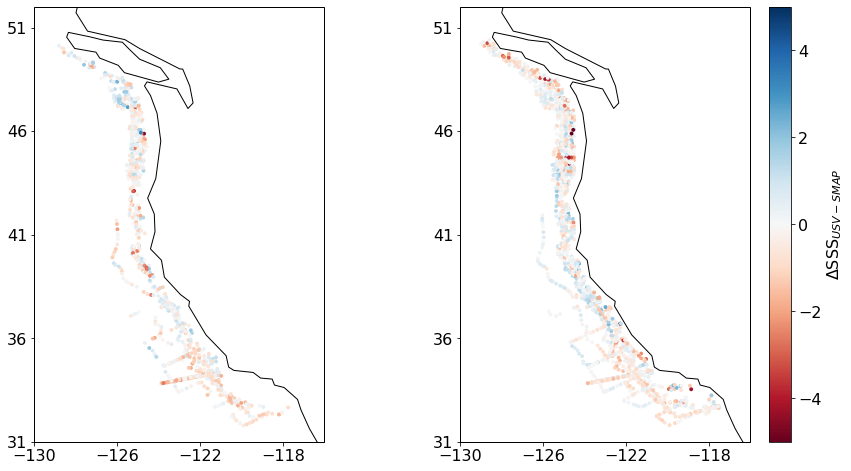

In [93]:
plt.rcParams['figure.figsize'] = (15.0,8.0)
plt.rcParams.update({'font.size': 16})

for i in range(13):
    ds=ds_colJ.isel(trajectory=i)
    ds = ds.where((ds.smap_iqc_flag<1))
#    ds = ds.where((ds.dist_land>25) & (ds.SAL_CTD_MEAN>26) & (ds.smap_iqc_flag<1))
    ax = plt.subplot(121,projection=ccrs.PlateCarree())
    cs1 = ax.scatter(ds.lon, ds.lat, s=15.0, c=ds.SAL_CTD_MEAN-ds.smap_SSS, edgecolor='none', cmap='RdBu',vmin=-5,vmax=5)
ax.coastlines()
#cs1.set_fontsize(16)
x1,x2,y1,y2 = -130,-116,31,52
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
ax.set_xticks(np.arange(x1,x2,4))
ax.set_yticks(np.arange(y1,y2,5))

for i in range(13):
    ds=ds_colR.isel(trajectory=i)
    ds = ds.where((ds.smap_iqc_flag<10000))
    ax = plt.subplot(122,projection=ccrs.PlateCarree())
    cs1 = ax.scatter(ds.lon, ds.lat, s=15.0, c=ds.SAL_CTD_MEAN-ds.smap_SSS, edgecolor='none', cmap='RdBu',vmin=-5,vmax=5)
ax.coastlines()
#cs1.set_fontsize(16)
x1,x2,y1,y2 = -130,-116,31,52
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
ax.set_xticks(np.arange(x1,x2,4))
ax.set_yticks(np.arange(y1,y2,5))

cax = plt.colorbar(cs1)
cax.set_label('$\Delta$SSS$_{USV-SMAP}$',fontsize=16)
fig_fname = 'C:/Users/gentemann/Google Drive/f_drive/docs/projects/SSS/figures/west_coast_collocations_sal_dif.png'
plt.savefig(fig_fname, transparent=False, format='png')

In [109]:
ds=ds_colJ.where((ds_colJ.smap_iqc_flag<1))
ds['dif_sal']=ds.SAL_CTD_MEAN-ds.smap_SSS
print('JPL',ds.dif_sal.mean().data,ds.dif_sal.std().data,(ds.dif_sal/ds.dif_sal).sum().data)
ds=ds_colR.where( (ds_colR.smap_iqc_flag<10000))
ds['dif_sal']=ds.SAL_CTD_MEAN-ds.smap_SSS
print('RSS',ds.dif_sal.mean().data,ds.dif_sal.std().data,(ds.dif_sal/ds.dif_sal).sum().data)

ds=ds_colJ.where((ds_colJ.dist_land>100)  & (ds_colJ.smap_iqc_flag<1))
ds['dif_sal']=ds.SAL_CTD_MEAN-ds.smap_SSS
print('JPL',ds.dif_sal.mean().data,ds.dif_sal.std().data,(ds.dif_sal/ds.dif_sal).sum().data)
ds=ds_colR.where((ds_colR.dist_land>100) & (ds_colR.smap_iqc_flag<10000))
ds['dif_sal']=ds.SAL_CTD_MEAN-ds.smap_SSS
print('RSS',ds.dif_sal.mean().data,ds.dif_sal.std().data,(ds.dif_sal/ds.dif_sal).sum().data)


JPL -0.20302986017057398 0.8782074041781945 993.0
RSS -0.1556086646876625 0.9211048081607605 1688.0
JPL -0.33395970096286787 0.789066091312463 337.0
RSS -0.13421557445472046 0.5969931480470536 399.0


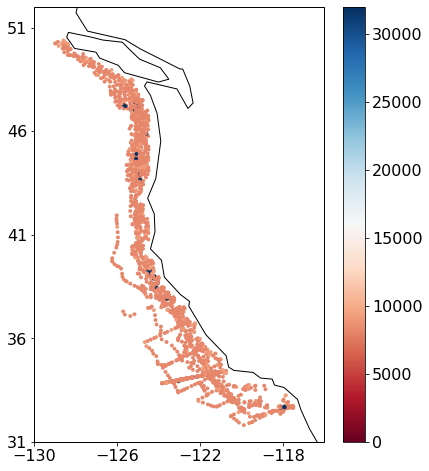

In [19]:
plt.rcParams['figure.figsize'] = (15.0,8.0)
plt.rcParams.update({'font.size': 16})

for i in range(13):
    ds=ds_colR.isel(trajectory=i)
    #ds = ds.where((ds.SAL_CTD_MEAN>26) & (ds.smap_iqc_flag<1))
#    ds = ds.where((ds.dist_land>25) & (ds.SAL_CTD_MEAN>26) & (ds.smap_iqc_flag<1))
    ax = plt.subplot(121,projection=ccrs.PlateCarree())
    cs1 = ax.scatter(ds.lon, ds.lat, s=15.0, c=ds.smap_iqc_flag, edgecolor='none', cmap='RdBu',vmin=0,vmax=32000)
ax.coastlines()
#cs1.set_fontsize(16)
x1,x2,y1,y2 = -130,-116,31,52
ax.set_xlim(x1,x2)
ax.set_ylim(y1,y2)
ax.set_xticks(np.arange(x1,x2,4))
ax.set_yticks(np.arange(y1,y2,5))
cax = plt.colorbar(cs1)



In [20]:
ds1 = xr.open_dataset('F:/data/sat_data/smap/SSS/L2/JPL/V4.3/2019/001/SMAP_L2B_SSS_20921_20190101T005415_R16022_V4.3.h5')
ds2 = xr.open_dataset('F:/data/sat_data/smap/SSS/L2/RSS/V4/SCI/2019/001/RSS_SMAP_SSS_L2C_r20921_20190101T005327_2019001_FNL_V04.0.nc')

In [40]:
ds

<xarray.Dataset>
Dimensions:                       (ob: 306)
Coordinates:
  * ob                            (ob) int64 0 1 2 3 4 5 ... 301 302 303 304 305
    trajectory                    float64 1.047e+03
Data variables: (12/37)
    lat                           (ob) float64 34.72 34.9 35.01 ... nan nan nan
    lon                           (ob) float64 -121.0 -121.1 -121.2 ... nan nan
    SOG_MEAN                      (ob) float64 0.8468 0.9945 0.6778 ... nan nan
    COG_MEAN                      (ob) float64 113.7 246.6 302.6 ... nan nan nan
    HDG_MEAN                      (ob) float64 110.4 279.8 300.3 ... nan nan nan
    PITCH_MEAN                    (ob) float64 -0.2013 -0.3245 ... nan nan
    ...                            ...
    smap_dist                     (ob) float64 0.1517 0.08698 0.1486 ... nan nan
    smap_ydim                     (ob) float32 498.0 499.0 499.0 ... nan nan nan
    smap_xdim                     (ob) float32 1.131e+03 1.131e+03 ... nan nan
    smap_rev_number               (ob) float64 2.438e+04 2.438e+04 ... nan nan
    dist_land                     (ob) float64 31.68 32.26 33.13 ... nan nan nan
    time                          (ob) datetime64[ns] 2019-08-25T11:30:00 ......
Attributes: (12/47)
    area:                      unassigned
    cdm_data_type:             Trajectory
    cdm_trajectory_variables:  trajectory
    Conventions:               CF-1.6, COARDS, ACDD-1.3
    creator_email:             support@saildrone.com
    creator_name:              Saildrone
    ...                        ...
    time_coverage_resolution:  PT1M
    time_coverage_start:       2018-07-17T18:00:00Z
    title:                     Saildrone West Coast Survey 2018
    uuid:                      3e4ce677-18db-4ba8-9c73-f2c1f3ad15ce
    Westernmost_Easting:       -124.915008
    vehicle_id:                sd1024

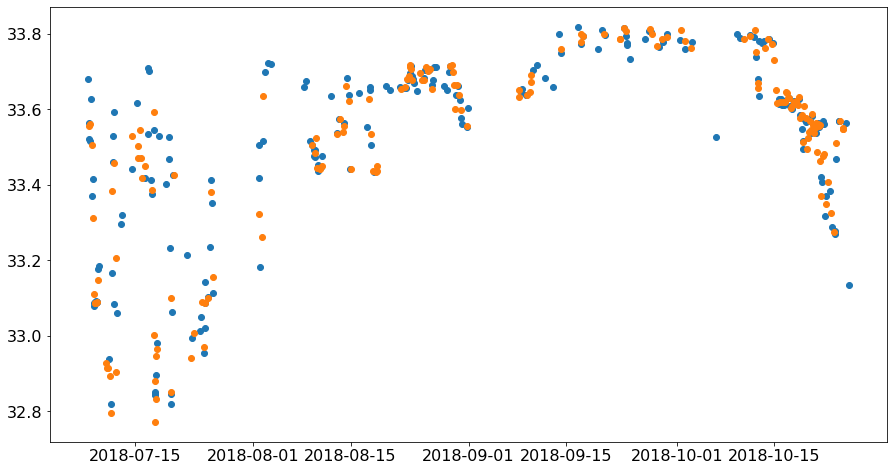

In [22]:
ds1=ds_colJ.isel(trajectory=2)
ds2=ds_colR.isel(trajectory=2)
plt.scatter(ds1.time.data,ds1.SAL_CTD_MEAN)
plt.scatter(ds2.time.data,ds2.SAL_CTD_MEAN)

In [23]:
import xarray as xr
xr.show_versions()


INSTALLED VERSIONS
------------------
commit: None
python: 3.7.10 | packaged by conda-forge | (default, Feb 19 2021, 15:37:01) [MSC v.1916 64 bit (AMD64)]
python-bits: 64
OS: Windows
OS-release: 10
machine: AMD64
processor: Intel64 Family 6 Model 63 Stepping 2, GenuineIntel
byteorder: little
LC_ALL: None
LANG: None
LOCALE: None.None
libhdf5: 1.10.5
libnetcdf: 4.6.2

xarray: 0.17.0
pandas: 1.2.4
numpy: 1.20.2
scipy: 1.6.3
netCDF4: 1.5.1.2
pydap: None
h5netcdf: 0.8.1
h5py: 2.10.0
Nio: None
zarr: 2.4.0
cftime: 1.4.1
nc_time_axis: None
PseudoNetCDF: None
rasterio: 1.0.25
cfgrib: 0.9.8.4
iris: None
bottleneck: 1.3.2
dask: 2.30.0
distributed: 2.30.0
matplotlib: 3.2.1
cartopy: 0.17.0
seaborn: 0.10.0
numbagg: None
pint: None
setuptools: 49.6.0.post20210108
pip: 21.1.1
conda: None
pytest: None
IPython: 7.23.0
sphinx: None
